___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Session - 10 Part -1<br><br>Univariate Time Series Forecasting with RNN<br><br>RSCCASN<br><h1>

# RNN (Time Series)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

Data setimiz, bir feature' a sahip ve Amerikada' ki Federal Reserve Bank' a ait giyim ve giyim aksesuarlari ile alakali aylik satis verilerini iceriyor. Tek bir feature' a ait bilgiler ile model kurmak cok saglikli degildir cunku satisi etkileyen bircok faktör vardir. Biz burda konuyu ögrenmek adina tek feature ile model kuracagiz. 

Hyperparametreleri calistirmadan sadece datasetini okuttugumuzda date ve milyon dolar seviyesinde bir data karsimiza cikiyor. __parse_dates=True__ ile date' i date formatina cevirdik, __index_col='DATE'__ ile de date sutununu index' e aldik. Timeseries ile calisirken time feature' i index' e alinir :

In [6]:
df = pd.read_csv('RSCCASN.csv',
                 index_col='DATE',
                 parse_dates=True
                )

In [7]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


Sütun ismini Sales' e cevirdik :

In [9]:
df.columns = ['Sales']

Satislar ayni trendi izlemesine karsin genel olarak zaman icinde bir yükselis oldugunu goruyoruz. Amacimiz forecast ile sonraki satis trendini tahmin etmek olacak (Disardaki diger etkenler hesaba katilmadan sadece zaman ile satis arasindaki iliskiye bakilmis) :

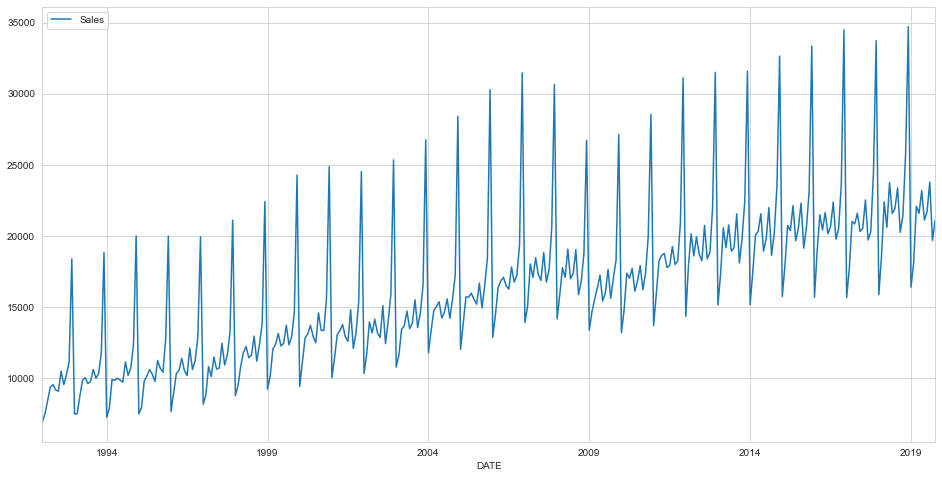

In [12]:
df.plot(figsize=(16,8));

## Preprocessing of Data

### Train Test Split

Datamiz aylik bir data, o halde 12 ayda bir periyot tamamlaniyor. Yani 12 satirda bir periyodu tamamlayacak. Modeldeki val_los' u kontrol etmek icin length=12 olacak.

In [13]:
len(df)

334

Test datasinin uzunlugunu sequence' larin uzunlugundan daha fazla almamiz gerekir. Bu yuzden test_size' i  sequence' in 2 kati uzunlugunda secerek 24 olarak belirledik :

In [14]:
test_size = 24

df uzunlugundan test_size uzunlugunu cikardik ve 310 sayisini elde ettik. 310. satirdan itibaren datamizi train ve test olarak bölecegiz :

In [15]:
test_ind = len(df)- test_size
test_ind

310

310. satirdan öncesi train, 310. satirdan sonrasi test datamiz olacak (Timeseries datalarda test datasi sondan alinmak zorunda) :

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-06-01,20322
2017-07-01,20535
2017-08-01,22536


In [12]:
test

,Sales
DATE,
2017-11-01,24438
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919


### Scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler

Robust scaler veya baska scaler cesitleri de kullanilabilirdi.

In [14]:
scaler = MinMaxScaler()

Tek feature uzerinde calistigimiz icin X_train, y_train datalari yok. Hem X hem de y ayni feature icinde.

In [15]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
# help(TimeseriesGenerator)

Aylik periyotlardan dolayi length=12 olarak belirledik. Data kucuk oldugu icin batch_size=1 secmek daha avantajli. TimeseriesGenerator icine scale edilmis train datasi, target olarak yine scale edilmis train datasini verdik.

TimeseriesGenerator icinde bir de __shuffle=False__ parametresi var. Bu parametre ANN ve CNN' de default olarak True idi fakat burda False. Cunku bu datalarda siralama önemli.

In [18]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

310 datadan 12' yi cikarinca, batch_size=1 oldugu icin 298 tane generator üretilmis oldu. (Son siradaki 12' yi yapamayacagi icin 12 cikardik) :

12 satir alacak, 13. satiri tahmin edecek, birer satir kaydirip sona kadar ayni islemi tekrar edecek.

In [19]:
len(generator)

298

Generator' in ilk elemaninda 12 data var bunlara göre en alttaki 13. elemani tahmin edecek :

In [20]:
generator[0]

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [21]:
X, y = generator[0]

Yukaridaki kodu daha okunakli hale getirdik :

In [22]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


## Modelling

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

Kac feature oldugunu elle yazmak yerine asagida bir degiskene tanimladik ki feature sayisi belirtmek gerekitiginde direk bu degiskeni kullanalim :

In [24]:
n_features = train_scaled.shape[1]

Modele iki hidden layer tanimladik. Ilk hidden layer' da 100 nöron var, aktivasyon fonksiyonu tanh (LSTM' de default deger).

__return_sequences=True -->__ Modelde birden fazla katman kuruldugunda sonraki katmana uygun data tipini sequence seklinde gönderebilsin (Sonraki katmana bir seri gitsin) .Bu kodu yazmazsak output' a gönderiyormus gibi tek bir çıktı gönderir. 

__input_shape = (length, n_features) -->__ Belirledigimiz uzunluk ve kac feature oldugu bilgisi.

__model.add(Dense(1)) -->__ 1 yerine n_features da yazilabilirdi.

In [25]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


LSTM ile kurulan modelde simple RNN' de kurulan modele göre 4 kat fazla parametre cikar. Parametre sayilarini hesaplama formulleri asagida :

In [16]:
# params = 4 * ((size_of_input + 1) * size_of_output + size_of_output^2)
4 * ((1+1)*100+(100**2))

40800

In [19]:
4 * ((100+1)*50+(50**2))

30200

### EarlyStopping and Validation Generator

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

EarlyStop icin validation data' si üretmemiz gerekiyor. Train datasini ürettigimiz gibi TimeseriesGenerator icine test datasini vererek, length ve batch_size' i belirterek validation datasini olusturduk :

In [31]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

Test datasinda 24 satirimiz vardi. length 12 oldugu icin 12 tane generator olusturdu :

In [32]:
len(validation_generator)

12

In [33]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
298/298 [==============================] - 13s 19ms/step - loss: 0.0222 - val_loss: 0.0361
Epoch 2/20
298/298 [==============================] - 4s 12ms/step - loss: 0.0197 - val_loss: 0.0382
Epoch 3/20
298/298 [==============================] - 4s 12ms/step - loss: 0.0194 - val_loss: 0.0267
Epoch 4/20
298/298 [==============================] - 4s 13ms/step - loss: 0.0181 - val_loss: 0.0294
Epoch 5/20
298/298 [==============================] - 4s 13ms/step - loss: 0.0162 - val_loss: 0.0247
Epoch 6/20
298/298 [==============================] - 3s 11ms/step - loss: 0.0164 - val_loss: 0.0375
Epoch 7/20
298/298 [==============================] - 3s 12ms/step - loss: 0.0167 - val_loss: 0.0257
Epoch 8/20
298/298 [==============================] - 5s 16ms/step - loss: 0.0139 - val_loss: 0.0192
Epoch 9/20
298/298 [==============================] - 4s 13ms/step - loss: 0.0138 - val_loss: 0.0275
Epoch 10/20
298/298 [==============================] - 4s 13ms/step - loss: 0.0126 - val_l

Model bazi yerlerde patlama yapti :

<AxesSubplot:>

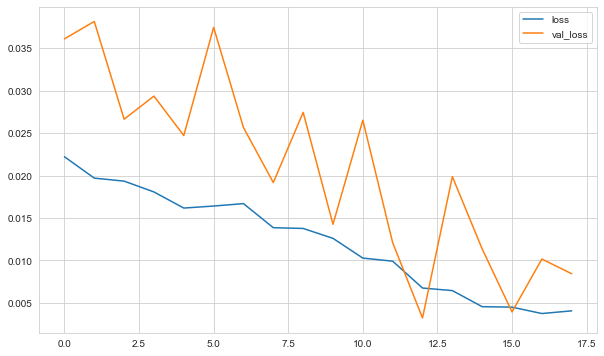

In [34]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

## Evaluate on Test Data

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [36]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

Asagidaki fonksiyon ile __Forecast__ islemi yapilacak. Train datasinin sondaki 'length' uzunlugu kadar kismi (son 12) alinacak, bir tahmin yapilacak. Bir asagi kaydirilarak ilk eleman iptal edilecek onun yerini yeni tahmin edilen deger alacak. Yine eldeki 12 dataya göre bir sonraki adim tahmin edilecek. Bu islem 12 kere tekrar edecek. Tahminler üzerine yeni tahminler yaptigimiz icin hata orani gittikce büyüyecektir. Forecast islemini uzatmak saglikli sonuclar vermez. Bu yüzden length uzunlugu kadar (1 yillik) tahmin yapmak istiyoruz. Yapilan her tahmin basta tanimlanan bos listenin icine atilacak.

first_eval_batch' de train datasinin son 12 satirini aldik, datanin devamini tahmin etmeye calisacagiz.

__reshape__ yapmamizin sebebi; generator iki boyutlu datayi 3 boyutlu hale cevirir. Prediction yaptiracagimiz sequence' i da modele uygun hale getirmek icin boyut artirma islemi yaptik.

__predictions_scaled.append(current_pred[0]) -->__ Bulunan prediction bos listeye eklenir. __[0]__ indexinin sebebi; yaptigimiz tahminin sonucu 2 boyutlu array cikar. Bu degeri bos listeye atip test datasiyla karsilastirabilmemiz icin tek boyutlu array haline getirmemiz gerekir. Bu islem ile sonucu tek boyuta indirmis olduk.

__current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1) -->__ Forecast isleminde ilk prediction' i iptal et, bir alta kayarak yeni prediction' i 12. eleman olarak al. Her seferinde ilk elemani iptal eder, onun yerine yeni bulunan prediction degerini koyar. __[current_pred]'__ i köseli parantez icine yazmamizin sebebi; current_batch 3 boyutlu ve onun altina eleman ekleyebilmemiz icin boyutunu 2 boyuttan 3' e cikarmamiz gerekir.

In [37]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))    

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

12 adet prediction degeri var. Scale edilmis bir data oldugu icin degerlendirme yapamiyoruz :

In [38]:
predictions_scaled

[array([0.582714], dtype=float32),
 array([0.78833985], dtype=float32),
 array([0.3446653], dtype=float32),
 array([0.41214722], dtype=float32),
 array([0.4814337], dtype=float32),
 array([0.47753483], dtype=float32),
 array([0.48078257], dtype=float32),
 array([0.4512664], dtype=float32),
 array([0.4593258], dtype=float32),
 array([0.47181666], dtype=float32),
 array([0.42137343], dtype=float32),
 array([0.46214837], dtype=float32)]

Train datasinin sonundan alip prediction yaptigimiz icin buldugumuz degerler test datasinin ilk 12 degeri. Kiyaslama yapabilmek icin scale edilmis test datasinin ilk 12 tanesini ve prediction degerlerimizi eval_metric icine vardik. Buldugumuz skor modeli her calistirdigimizda degisiklik gösterebilir :

In [39]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.6300043786104159 
mae: 0.07622855486378388 
mse: 0.008194450439270693 
rmse: 0.09052320387210504


### Inverse Transformations and Comparing

Scale edilmis prediction degerlerimizi inverse yaparak degerleri orjinal hale cevirip gercek degerlerle kiyaslayacagiz :

In [40]:
predictions = scaler.inverse_transform(predictions_scaled)

Test datasinin ilk 12' sini alarak bir degiskene attik ve yeni bir DataFrame olusturduk. Bunun yanina prediction' lari sütun olarak ekledik :

In [41]:
compare = test[:12]

In [42]:
compare['Predictions'] = predictions

In [43]:
compare

,Sales,Predictions
DATE,,
2017-11-01,24438,22988.275
2017-12-01,33720,28652.033
2018-01-01,15881,16431.461
2018-02-01,18585,18290.183
2018-03-01,22404,20198.610
2018-04-01,20616,20091.219
2018-05-01,23764,20180.675
2018-06-01,21589,19367.682
2018-07-01,21919,19589.670


Mavi renkli olanlar gercek degerler, turuncular prediction degerleri. Tahminlerde keskin noktalardaki degerleri yakalayabilmis. Prediction üzerine prediction kurdukca, ilerleyen noktalarda tahminlerin kötülestigini görüyoruz. Bu yüzden forecast islemini cok fazla uzatmamak gerekir :

Bu sekilde 12 aylik satis tahminleri alinmis oldu. Bu degerlere bakarak her ay ortalama olarak ne kadar satis yapilacagi bilgisine ulasilip ona göre stoklama yapilabilir.

<AxesSubplot:xlabel='DATE'>

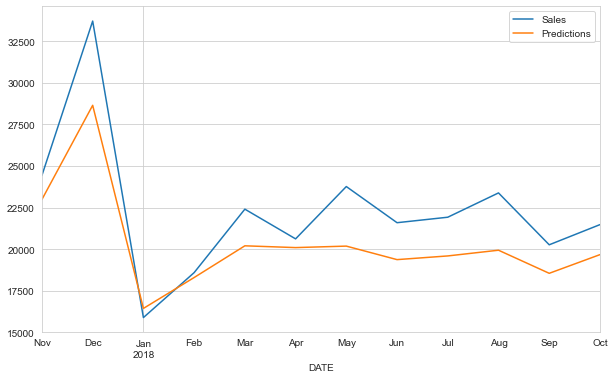

In [44]:
compare.plot()

Scale edilmemis data ve scale edilmemis prediction ile de yukaridaki ayni skoru aldik (mae: 2099 dolarlik bir hata yapilmis) :

In [45]:
eval_metrics(compare.Sales, compare.Predictions)

r2_score: 0.6300043786104151 
mae: 2099.639315168066 
mse: 6216899.579217561 
rmse: 2493.371127453264


## Retrain and Forecasting

Modeli kurup test ettikten sonra tüm datamizi egitecegiz ve ileriye dogru forecast yapacagiz. Bu sefer elimizde kiyaslama icin bir data olmayacak. 

In [46]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

Butun datayi scale ettik ve TimeseriesGenerator icine vererek egitim icin bir data ürettik :

In [47]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

df uzunlugu 334, generator uzunlugu 334-12=322 

In [48]:
len(df)

334

In [49]:
len(generator)

322

Elimizde validation datasi olmadigi icin EarlyStop koymadik. Hicbir degisiklik yapmadan modelimizi yukaridaki gibi kurduk :

In [50]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
322/322 [==============================] - 13s 11ms/step - loss: 0.0253
Epoch 2/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0197
Epoch 3/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0176
Epoch 4/15
322/322 [==============================] - 4s 12ms/step - loss: 0.0172
Epoch 5/15
322/322 [==============================] - 4s 12ms/step - loss: 0.0158
Epoch 6/15
322/322 [==============================] - 4s 13ms/step - loss: 0.0161
Epoch 7/15
322/322 [==============================] - 4s 12ms/step - loss: 0.0138: 1s - - ETA: 0s - los
Epoch 8/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0153
Epoch 9/15
322/322 [==============================] - 4s 13ms/step - loss: 0.0171
Epoch 10/15
322/322 [==============================] - 4s 13ms/step - loss: 0.0115
Epoch 11/15
322/322 [==============================] - 4s 12ms/step - loss: 0.0110
Epoch 12/15
322/322 [==============================] - 4s 12ms/step - loss

In [51]:
scaled_full_data.shape

(334, 1)

In [52]:
scaled_full_data[-length:].shape

(12, 1)

Onceki forecast isleminde train datasinin son 12 verisini alip forecast islemi yapmistik simdi ise tum datanin son 12 verisini alarak forecast islemi yapacagiz :

In [53]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [54]:
forecast = scaler.inverse_transform(forecast)

In [55]:
forecast

array([[26134.25937986],
       [30541.52502203],
       [17557.05377793],
       [18956.92175317],
       [20724.9120183 ],
       [20512.99078059],
       [21002.74214411],
       [19797.37889814],
       [20075.81647158],
       [20588.13533521],
       [18715.82907462],
       [20484.16656995]])

In [56]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


Gercek data ile forecast tahminlerimizi birlestirecegiz. Datamizdaki son veri 2019-10-01 tarihinde bitiyordu. Tahmin degerlerimizin bir sonraki ay olan 2019-11-01 tarihinden itibaren baslamasi ve 12 ay boyunca devam etmesi gerekiyor. Forecast' leri bu tarihlere gore indexlememiz gerekiyor. Bunun icin __date_range__ fonksiyonunu kullandik. Bu fonksiyon icine baslangic zamani verip length uzunlugu kadar (12) bu islemi yapmasini istedik. Frekansini da month anlamina gelen "MS" olarak belirledik (MS --> Ayin birinci gunleri anlamina geliyor) :

In [57]:
forecast_index = pd.date_range(start = '2019-11-01', periods = length, freq = 'MS')

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [58]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

Indexledigimiz forecast array halinde, bunu DataFrame haline getirdik :

In [59]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [60]:
forecast_df

,Forecast
2019-11-01,26134.259
2019-12-01,30541.525
2020-01-01,17557.054
2020-02-01,18956.922
2020-03-01,20724.912
2020-04-01,20512.991
2020-05-01,21002.742
2020-06-01,19797.379
2020-07-01,20075.816
2020-08-01,20588.135


Orjinal df ile forecast' i birlikte plotlayarak arka arkaya bir görüntü elde etmis olduk :

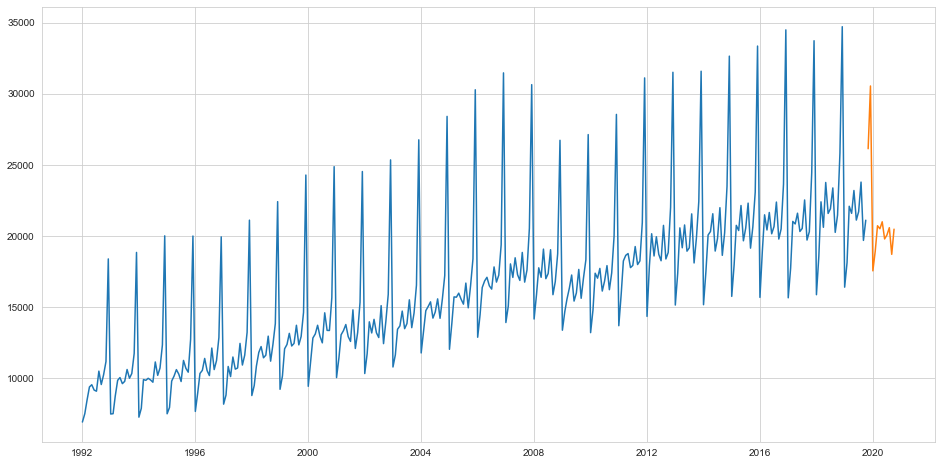

In [61]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

Plot yontemi yerine iki datayi concat islemi ile birlestirseydik yine arka arkaya ekleneceklerdi fakat gercek data ile forecast arasinda renk ayrimi olmayacakti. Bu yuzden plotlama yontemini tercih ediyoruz.

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

Yukaridaki grafigi elde etmenin daha kolay bir yolu var. Digerine gore daha buyuk olan datayi (df) plotlayarak bir degiskene atadik. Sonrasında forecast_df' i plotlayarak icine df' i attigimiz degiskeni verdik. Bu sekilde iki datayi arka arkaya cizdirmis olduk :

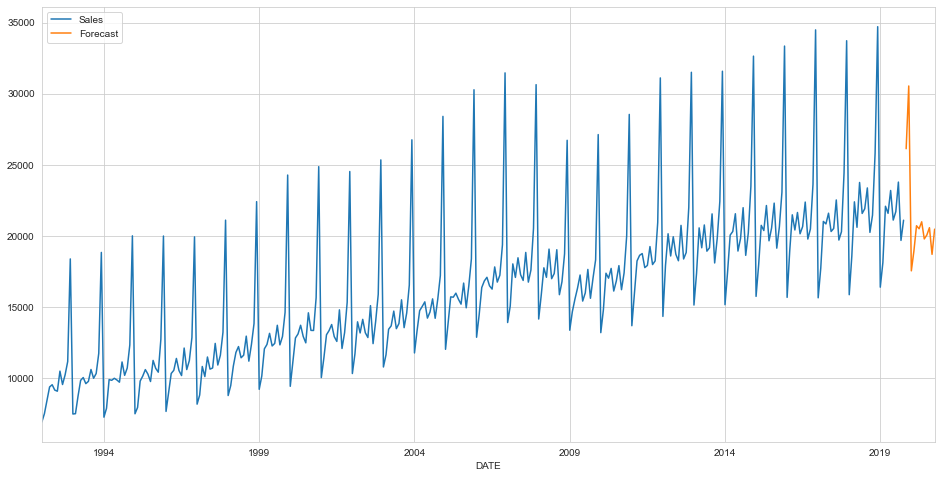

In [62]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

Bu yontemi kullandigimizda __xlim__ ile istedigimiz bir kismi daha ayrintili bir sekilde gorsellestirebiliriz (Diger yöntemde bu mümkün degil) :

(576.0, 611.0)

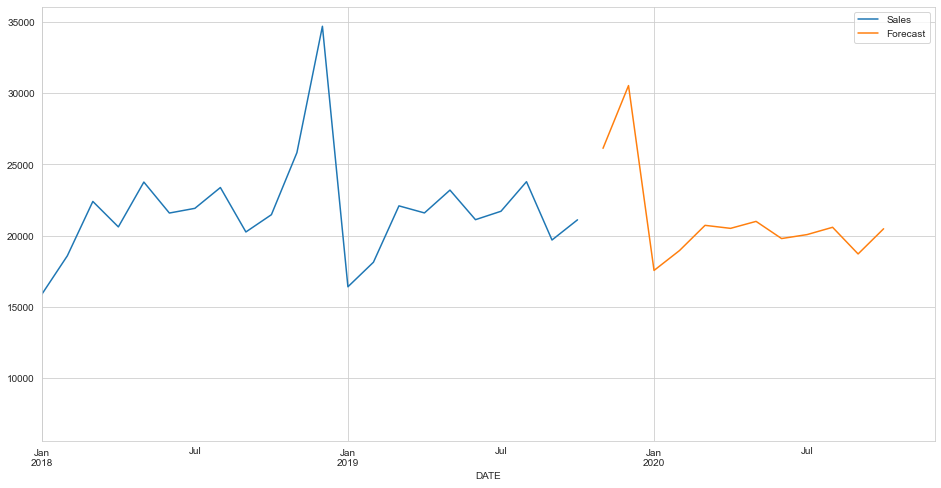

In [63]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')

tanh yerine ReLu aktivasyon fonksiyonu tanimlanarak da skorlara bakilabilir.

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___